In [165]:
%matplotlib inline

In [166]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs 

### Helper functions

In [167]:
def distance(xs, centroid):
    """Computes matrix of squared distance from each point to each centroid.
    
    Parameters:
    -----------
    xs : ndarray of n points in d dimensional Euclidean space (nxd)
    centroid: ndarray of k centroids in d dimensional Euclidean space (kxd)
    
    Returns:
    --------
    distance: matrix of squared distances (nxk)
    """

    distance = np.sum((xs[:,None,:] - centroid)**2, axis=-1)
    return distance

In [168]:
def cost(d):
    """Computes the cost of a set of points with respect to a collection of centroids
    
    Parameters:
    -----------
    d : matrix of squared distances (nxk); likely returned from distance() function
    
    Returns:
    --------
    cost: cost with respect to centroids
    """
    #calculate distance to the nearest centroid for each point
    min_dist = np.min(distance(xs, centroid), axis = 1)
    
    #compute cost
    cost = np.sum(min_dist)
    return cost

In [169]:
def centroid_weights(d):
    """Computes weights as defined in step 7 of the k-means|| algorithm
        
    Parameters:
    -----------
    d : matrix of squared distances (nxk); likely returned from distance() function
    
    Returns:
    --------
    w_x: ndarray of weights applied to centroids (kx1)
    """
    #identify closest centroid to each point
    c_close = np.zeros(d.shape)
    c_close[np.range(d.shape[0]), np.argmin(d, axis = 1)] = 1
    
    #compute the weights
    w_x = np.sum(c_close, axis = 0)
    return w_x

### K-means ++ initialization (Section 3.1)

In [170]:
def k_means_pp(xs, k, seed=None):
    """
    Implements the K_means++ Initialization algorithm
    
    Parameters:
    -----------
    xs: input dataset
    k: the number of output clusters
    seed: an optional random seed
    
    Returns:
    --------
    C: the reclustered k centroids used to initialize the k-means algorithm
    """
    #initialization
    np.random.seed(seed)
    C = xs[np.random.choice(xs.shape[0],1),:]
    loop = 0
    
    while len(C)<k:
        
        if (loop % 10 == 0):
            print("The current loop is:", loop)
        
        dist = distance(xs,C)
        cst = cost(dist)
        
        probs_x = np.min(dist, axis = 1)/cst
        C_new = xs[np.random.choice(xs.shape[0],1,p=probs_x),:]
        
        C = np.vstack((C,C_new))
        
        loop += 1
        
    return C

### K-means || initialization (Section 3.3)

In [171]:
def K_Means_parallel(xs, k, l, seed=None):
    """Implements the K_means || algorithm
    
    Parameters:
    -----------
    xs : ndarray of n points in d dimensional Euclidean space (nxd)
    k: the number of output clusters
    l: the oversampling factor; the number of centroids to sample at each iteration
    seed: an optional random seed
    
    Returns:
    --------
    C: the reclustered k centroids used to initialize the k-means algorithm
    """
    
    #initialization
    np.random.seed(seed)
    centroid = xs[np.random.choice(xs.shape[0],1),:]
    order = np.floor(cost(xs,centroid))
    
    ##should we add condition to run minimum # of times unless dataset sufficiently large?
    
    for i in np.arange(np.log10(order)):
        dist = distance(xs,centroid)
        cst = cost(dist)
        
        probs_x = np.min(dist, axis = 1)/cst
        centroid_new = xs[np.random.choice(xs.shape[0],l,p=probs_x),:]
        
        centroid = np.vstack((centroid,centroid_new))
        
    dist = distance(xs,centroid)
    weight = centroid_weights(dist)
    
    #Implement k-means++ to recluster weighted points in C
    w_C = weight*centroid
    C = k_means_pp(w_C,k,seed=seed)
    #C = centroid[np.random.choice(centroid.shape[0],k,replace=False,p=weight),:]
    return C

### K-means Algorithm

In [186]:
def k_means(X, k, centroids):
    """
        This function will separate X into k clusters using the classic k-means
        algorithm.
    """
    ## parameters
    max_iter = 1000
    step = 0
    #n, p = X.shape
    
    ## run the algorithm
    while step < max_iter:
        ### sort the data in terms of clusters
        dist = distance(X, centroids)
        cluster_indices = np.argmin(dist, axis=1)
        
        ### update centroids
        update_centroids = np.zeros(centroids.shape)
        for i in range(k):
            update_centroids[i,:] = np.mean(X[cluster_indices==i,:], axis=0)
        
        ### check conditions
        if np.array_equal(update_centroids, centroids):
            break
        else:
            centroids = update_centroids
            
            if (step % 5 == 0):
                print("We are currently at {} step".format(step))
            
            step += 1
    
    total_dist = distance(X, centroids)
            
    return {"Centroids": centroids,
            "Cluster Indices": cluster_indices,
            "Number of Iterations": step}

### The Parallel Implementation (Section 3.5)

### Multiprocessing

In [114]:
from multiprocessing import Pool, cpu_count
from functools import partial
from collections import Counter

#### Helper functions

In [109]:
def min_dist(point, centroid):
    """Computes the squared distance to the nearest centroid for a given data point"""
    min_dist = np.min(np.sum((point - centroid)**2, axis=-1))
    return min_dist

def close_cent(point, centroid):
    """Returns the index of the closest centroid to a given data point"""
    index = np.argmin(np.sum((point - centroid)**2, axis=-1))
    return index

#### Functions in Parallel

In [106]:
def probs_x_p(xs, centroid, cpu=None):
    """Computes the probabilities for sampling a new centroid(s)
    for a given set of centroids and the data in parallel
    
    Also returns the intermediary cost value
    """
    p_min_dist = partial(min_dist, centroid=centroid)
    with Pool(processes = cpu) as pool:
        min_d = pool.map(p_min_dist,xs)
        cost = np.sum(min_d)
        prob_x = min_d/cost
    return cost, prob_x

In [141]:
def weights_p(xs, centroid, cpu=None):
    """Computes the weights for each centroid in parallel"""
    
    p_close_cent = partial(close_cent, centroid=centroid)
    with Pool(processes = cpu) as pool:
        indeces = pool.map(p_close_cent, xs)
        w_x = np.array([Counter(indeces)[i] for i in np.arange(centroid.shape[0])])
    return w_x

In [144]:
def K_Means_parallel_p(xs, k, l, seed=None):
    """Implements the K_means || algorithm using parallel intermediary functions
    
    Parameters:
    -----------
    xs : ndarray of n points in d dimensional Euclidean space (nxd)
    k: the number of output clusters
    l: the oversampling factor; the number of centroids to sample at each iteration
    seed: an optional random seed
    
    Returns:
    --------
    C: the reclustered k centroids used to initialize the k-means algorithm
    """
    
    #initialization
    np.random.seed(seed)
    centroid = xs[np.random.choice(xs.shape[0],1),:]
    order = np.floor(probs_x_p(xs,centroid)[0])
    
    ##should we add condition to run minimum # of times unless dataset sufficiently large?
    
    for i in np.arange(np.log10(order)):
        
        probs_x = probs_x_p(xs,centroid)[1]
        centroid_new = xs[np.random.choice(xs.shape[0],l,p=probs_x),:]
        
        centroid = np.vstack((centroid,centroid_new))
        
    weight = weights_p(xs,centroid)
    
    #Implement k-means++ to recluster weighted points in C
    w_C = weight*centroid
    C = k_means_pp(w_C,k,seed=seed)
    #C = centroid[np.random.choice(centroid.shape[0],k,replace=False,p=weight),:]
    return C

In [147]:
xs = GM[0] #data is from GaussMix dataset
cent = xs[np.random.choice(xs.shape[0],5),:]

probs_x_p(xs,cent)

(1595129.0317715453,
 array([2.26745853e-05, 1.95234704e-05, 2.35622926e-05, ...,
        1.42536751e-04, 1.51262190e-05, 6.88911183e-05]))

In [148]:
weights_p(xs,cent)

array([2511, 1008, 3115, 1028, 2338])

### Generate GaussMixture synthetic data for testing (Section 4.1)

In [145]:
def GaussMix(R, k, n=10000, d=15, seed=None):
    """Generates GaussMixture synthetic dataset"""
    np.random.seed(seed)
    mu = np.zeros(d)
    sigma = np.diag(R*np.ones(d))
    centers = np.random.multivariate_normal(mean=mu, cov=sigma, size=k)
    
    X,y = make_blobs(n_samples=n, n_features=d, centers=centers, random_state=seed)
    return X,y

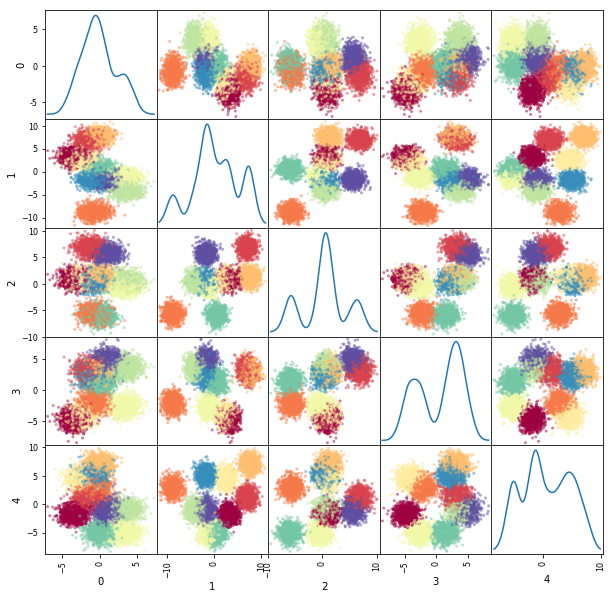

In [182]:
k=10
GM = GaussMix(10,k,seed=123)
df = pd.DataFrame(GM[0])
y = GM[1]
pd.plotting.scatter_matrix(df.iloc[:,0:5], c=y, figsize=(10,10),
                           diagonal='kde', alpha=0.5, cmap='Spectral')
pass

In [187]:
#using a random initialization
xs = GM[0]
np.random.seed(123)
c_int = xs[np.random.choice(xs.shape[0],k,replace=False),:]
pred = k_means(xs,k,c_int)

We are currently at 0 step
We are currently at 5 step
We are currently at 10 step
We are currently at 15 step
We are currently at 20 step
We are currently at 25 step


In [231]:
np.sum(y==pred['Cluster Indices'])/len(y)

0.2348

In [232]:
from sklearn.cluster import KMeans

plib = KMeans(k,init='random',random_state=123,n_init=1).fit(xs)
plib.labels_

array([3, 6, 5, ..., 5, 8, 8], dtype=int32)

In [233]:
np.sum(plib.labels_ == y)/len(y)

0.2348

In [ ]:
colors plt.cm.Spectral(np.linspace(0,1,k))
fig, ax = plt.subplots()
for i in range(k):
        points = np.array([X[j] for j in range(len(X)) if clusters[j] == i])
        ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[i])
ax.scatter(C[:, 0], C[:, 1], marker='*', s=200, c='#050505')